# Contextualized Models And Outlier Robustness

Contextualized models allow the effect to change as context changes. Therefore, context-dependent noise sources only have local effects and disrupt the estimated models in a neighborhood of context, rather than disrupting the single model used for all samples in a population model. 

In this notebook, we will assess the robustness of contextualized models when faced with outliers. We'll begin by training the models using data that **doesn't** include any outliers, and then we'll proceed to include outlier data to observe how well the models maintain their performance.

## 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from contextualized.easy import ContextualizedRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

### 1A. Preparing non-outlier data
We will use the sklearn diabetes for a realistic toy regression problem.

In [2]:
X, Y = load_diabetes(return_X_y=True, as_frame=True)
Y = np.expand_dims(Y.values, axis=-1)
C = X[['age', 'sex', 'bmi']]
X.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

# center and scale data
X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()
C = (C - C.mean()) / C.std()

seed = 1
train_idx, test_idx = train_test_split(range(len(C)), test_size=0.20, random_state=seed)
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]
C_train, C_test = C.iloc[train_idx], C.iloc[test_idx]

### 1B. Preparing outlier data
To simulate a localized outlier effect, we corrupt the data in a region of context.

/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/blengerich/Dro

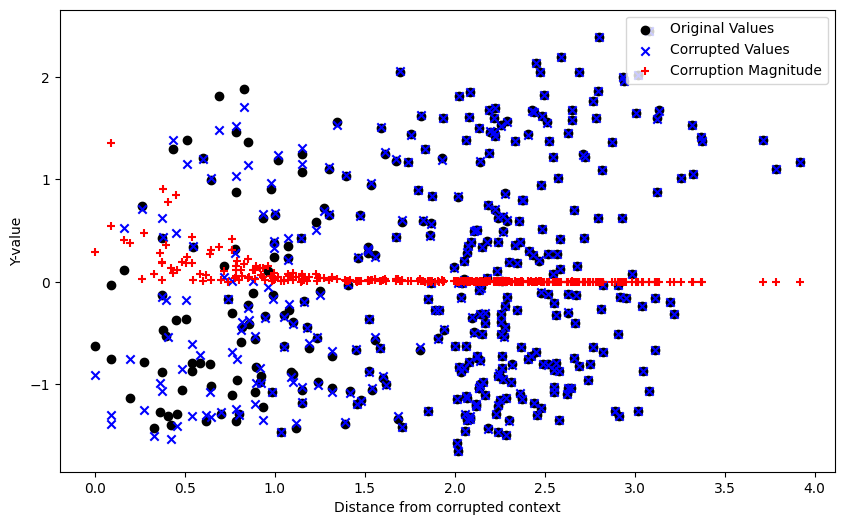

In [3]:
seed = 1
Y_train_outlier = Y_train.copy()
Y_test_outlier = Y_test.copy()

# find nearest neighbors in C_train_outlier to modify output values
knn_model = NearestNeighbors(n_neighbors=len(C_train))
knn_model.fit(C_train)
query_value = C_train.iloc[0:1] # "Corrupted" context
distances, indices = knn_model.kneighbors(query_value)
distances = distances.flatten()
neighbor_indices = indices.flatten()
# modifying values at indices
for i, (dist, idx) in enumerate(zip(distances, neighbor_indices)):
    Y_train_outlier[idx, 0] = np.random.normal(
        Y_train_outlier[idx, 0],
        np.exp(-10*dist/np.max(distances)), size=(1, 1))

fig = plt.figure(figsize=(10, 6))
plt.scatter(distances, Y_train[neighbor_indices], marker='o', color='black', label='Original Values')
plt.scatter(distances, Y_train_outlier[neighbor_indices], marker='x', color='blue', label='Corrupted Values')
plt.scatter(distances, np.abs(Y_train_outlier[neighbor_indices] - Y_train[neighbor_indices]), marker='+', color='red', label='Corruption Magnitude')
plt.xlabel('Distance from corrupted context')
plt.ylabel("Y-value")
plt.legend(loc='upper right')
plt.show()

## 2. How well do the models perform on the non-outlier data?
### 2A. Fit a population model to non-outlier data.

In [4]:
%%capture
# Initialize and train a linear regression model
sk_train = pd.concat([C_train, X_train], axis=1)
sk_test = pd.concat([C_test, X_test], axis=1)

sklearn_regressor = LinearRegression()
sklearn_regressor.fit(sk_train, Y_train)
preds = {
    "sklearn": 
             {"normal": 
                 {
                     "train": sklearn_regressor.predict(sk_train).reshape(-1), 
                     "test": sklearn_regressor.predict(sk_test).reshape(-1)
                 }
             }
}

### 2B. Fit a contextualized regressor to non-outlier data.

In [5]:
%%capture
context_regressor = ContextualizedRegressor(n_bootstraps=10)
context_regressor.fit(C_train.values, X_train.values, Y_train,
                      encoder_type="mlp", max_epochs=3,
                      learning_rate=1e-3)

preds["contextualized"] = {
    "normal": 
        {
         "train": context_regressor.predict(C_train.values, X_train.values)[:, 0], 
         "test": context_regressor.predict(C_test.values, X_test.values)[:, 0]
        }
}

### 2C. Evaluate model performances

Mean Squared Error (Population model): 0.48 (train), 0.50 (test)
Mean Squared Error (Contextualized regressor): 0.45 (train), 0.56 (test)


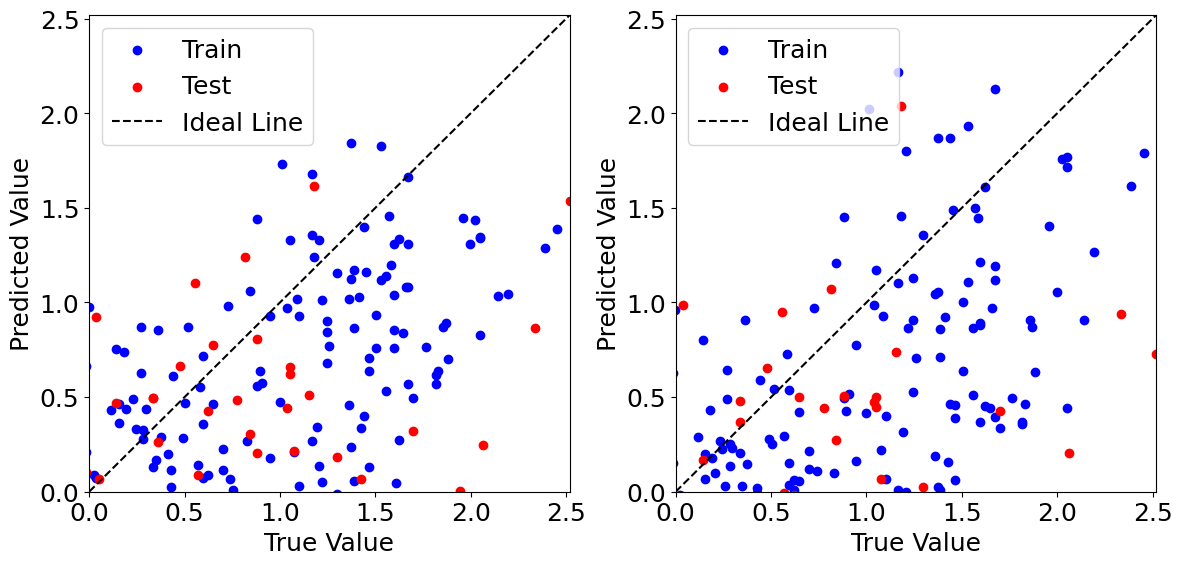

In [6]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

def plot_true_pred(Y_train, Y_test, train_preds, test_preds, ax):
    ax.scatter(Y_train[:, 0], train_preds, color='blue', label='Train')
    ax.scatter(Y_test[:, 0], test_preds, color='red', label='Test')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    max_true_value = np.max([np.max(Y_train[:, 0]), np.max(Y_test[:, 0])])
    ax.set_xlim([0, max_true_value])
    ax.set_ylim([0, max_true_value])
    ax.plot([0, max_true_value], [0, max_true_value], color='black', linestyle='--', label='Ideal Line')
    ax.legend()  # Display the legend

plot_true_pred(Y_train, Y_test, preds["sklearn"]["normal"]["train"], preds["sklearn"]["normal"]["test"], axes[0])
plot_true_pred(Y_train, Y_test, preds["contextualized"]["normal"]["train"], preds["contextualized"]["normal"]["test"], axes[1])
plt.tight_layout()

mse_sklearn_train = mean_squared_error(Y_train[:, 0], preds["sklearn"]["normal"]["train"])
mse_contextualized_train = mean_squared_error(Y_train[:, 0], preds["contextualized"]["normal"]["train"])

mse_sklearn_test = mean_squared_error(Y_test[:, 0], preds["sklearn"]["normal"]["test"])
mse_contextualized_test = mean_squared_error(Y_test[:, 0], preds["contextualized"]["normal"]["test"])

print(f"Mean Squared Error (Population model): {mse_sklearn_train:.2f} (train), {mse_sklearn_test:.2f} (test)")
print(f"Mean Squared Error (Contextualized regressor): {mse_contextualized_train:.2f} (train), {mse_contextualized_test:.2f} (test)")

The models perform very similarly on the non-outlier data (if anything, the population model is slightly better). Now let's introduce outliers in the dataset and see how the models hold up.

## 3. Now let's see how the models perform on the outlier data.

### 3A. Fit a population model to outlier data.

In [7]:
%%capture
# Initialize and train a linear regression model
sklearn_regressor = LinearRegression()
sklearn_regressor.fit(sk_train, Y_train_outlier)

preds["sklearn"]["outlier"] = {
    "train": sklearn_regressor.predict(sk_train).reshape(-1), 
    "test": sklearn_regressor.predict(sk_test).reshape(-1)
}

### 3B. Fit a contextualized regressor to data with outliers.

In [8]:
%%capture
context_regressor = ContextualizedRegressor(n_bootstraps=10)
context_regressor.fit(C_train.values, X_train.values, Y_train_outlier,
          encoder_type="mlp", max_epochs=3,
          learning_rate=1e-3)

preds["contextualized"]["outlier"] = {
    "train": context_regressor.predict(C_train.values, X_train.values)[:, 0], 
    "test": context_regressor.predict(C_test.values, X_test.values)[:, 0]
}

### 3C. Evaluate Performance on data with outliers.

Mean Squared Error (Population model): 0.48 (train), 0.50 (test)
Mean Squared Error (Contextualized regressor): 0.46 (train), 0.55 (test)


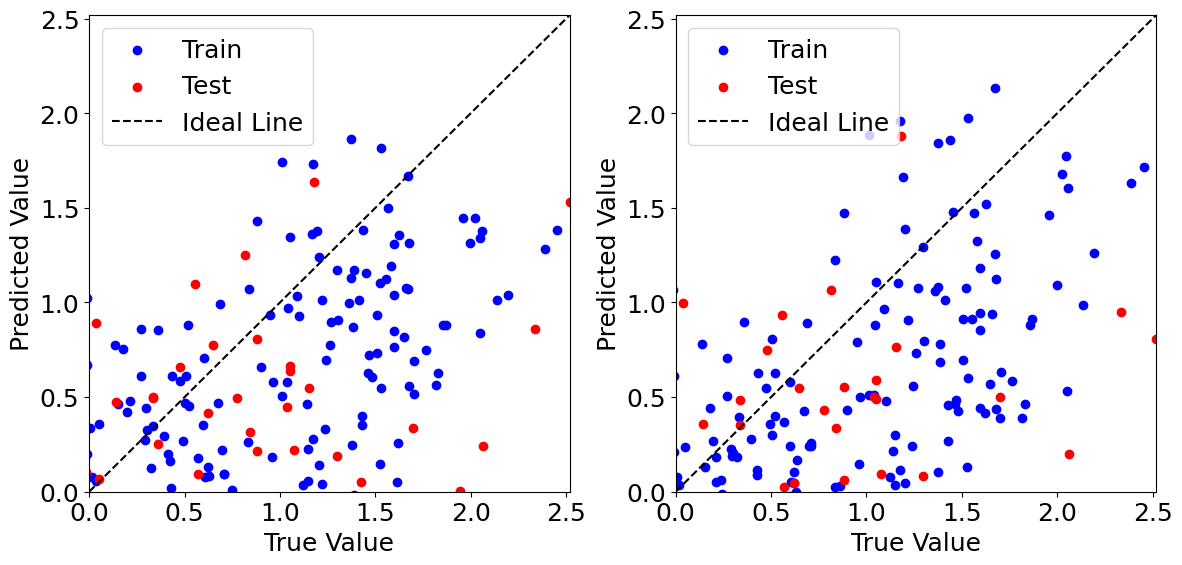

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

mse_sklearn_train = mean_squared_error(Y_train_outlier[:, 0], preds["sklearn"]["outlier"]["train"])
mse_contextualized_train = mean_squared_error(Y_train_outlier[:, 0], preds["contextualized"]["outlier"]["train"])

mse_sklearn_test = mean_squared_error(Y_test_outlier[:, 0], preds["sklearn"]["outlier"]["test"])
mse_contextualized_test = mean_squared_error(Y_test_outlier[:, 0], preds["contextualized"]["outlier"]["test"])

print(f"Mean Squared Error (Population model): {mse_sklearn_train:.2f} (train), {mse_sklearn_test:.2f} (test)")
print(f"Mean Squared Error (Contextualized regressor): {mse_contextualized_train:.2f} (train), {mse_contextualized_test:.2f} (test)")


plot_true_pred(Y_train_outlier, Y_test_outlier, preds["sklearn"]["outlier"]["train"], preds["sklearn"]["outlier"]["test"], axes[0])
plot_true_pred(Y_train_outlier, Y_test_outlier, preds["contextualized"]["outlier"]["train"], preds["contextualized"]["outlier"]["test"], axes[1])
plt.tight_layout()
plt.show()

The performance of the sklearn regressor quickly degrades when faced with outlier data. In contrast, the contextualized regressor is more robust to these outliers.

#### Let's check how this error changes with context (distance from corrupted value)

/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/blengerich/Dropbox/Professional/Research/Libraries/Contextualized/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/blengerich/Dro

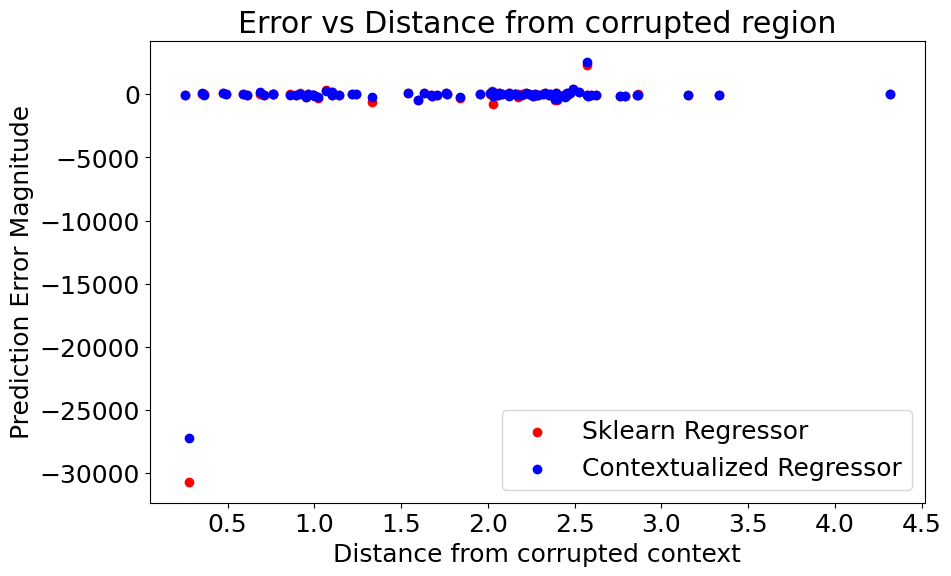

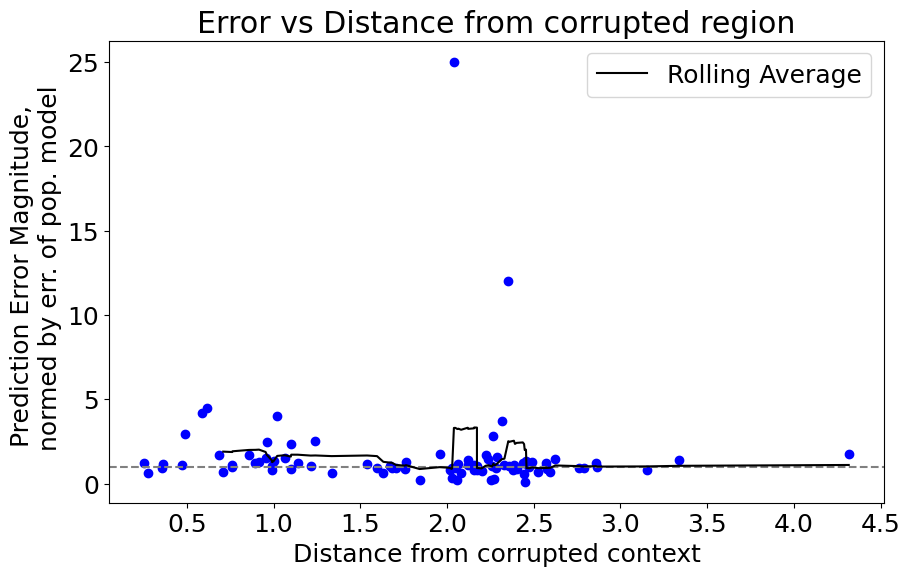

In [10]:
# Calc absolute errors of predictions
errors_sklearn_outlier = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_outlier[:, 0], preds["sklearn"]["outlier"]["test"])]
errors_context_outlier = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_outlier[:, 0], preds["contextualized"]["outlier"]["test"])]

# Normalize the errors by the errors of the population model
normalized_errors_sklearn_outlier = np.array(errors_sklearn_outlier) / np.array(errors_sklearn_outlier)
normalized_errors_context_outlier = np.array(errors_context_outlier) / np.array(errors_sklearn_outlier)

assert np.allclose(normalized_errors_sklearn_outlier, np.ones(len(normalized_errors_sklearn_outlier)))
# Normalized errors for the population model should all be about 1.

# Sort the distances and errors by distance
knn_model = NearestNeighbors(n_neighbors=len(C_test))
knn_model.fit(C_test)
distances, indices = knn_model.kneighbors(query_value)
distances = distances.flatten()

normalized_errors_context_outlier = normalized_errors_context_outlier[indices.flatten()]
plt.figure(figsize=(10, 6))
plt.scatter(distances, errors_sklearn_outlier, color='red', label='Sklearn Regressor')
plt.scatter(distances, errors_context_outlier, color='blue', label='Contextualized Regressor')
plt.xlabel('Distance from corrupted context')
plt.ylabel('Prediction Error Magnitude')
plt.title('Error vs Distance from corrupted region')
plt.legend()

normalized_errors_context_outlier = normalized_errors_context_outlier[indices.flatten()]
plt.figure(figsize=(10, 6))
plt.scatter(distances, normalized_errors_context_outlier, color='blue')
plt.xlabel('Distance from corrupted context')
plt.ylabel('Prediction Error Magnitude, \n normed by err. of pop. model')
plt.title('Error vs Distance from corrupted region')
plt.axhline(y=1, color='gray', linestyle='--')

# Plot the rolling average
window_size = 10
rolling_average = np.convolve(normalized_errors_context_outlier, np.ones(window_size), 'valid') / window_size
plt.plot(distances[window_size - 1:], rolling_average, color='black', label='Rolling Average')

#plt.ylim(0, 10)
plt.legend()
plt.show()